<a href="https://colab.research.google.com/github/MAICHIVINH/BachHoaXanh/blob/master/02_2_Seam_carving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!wget -O crop_c_image https://karthikkaranth.me/img/blog/implementing-seam-carving-with-python/pietro-de-grandi-329892-unsplash.jpg
!wget -O crop_r_image https://karthikkaranth.me/img/blog/implementing-seam-carving-with-python/brent-cox-455716-unsplash.jpg

--2025-02-22 07:44:57--  https://karthikkaranth.me/img/blog/implementing-seam-carving-with-python/pietro-de-grandi-329892-unsplash.jpg
Resolving karthikkaranth.me (karthikkaranth.me)... 54.215.62.21, 13.52.115.166
Connecting to karthikkaranth.me (karthikkaranth.me)|54.215.62.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97818 (96K) [image/jpeg]
Saving to: ‘crop_c_image’

crop_c_image        100%[===================>]  95.53K  --.-KB/s    in 0.07s   

2025-02-22 07:44:57 (1.37 MB/s) - ‘crop_c_image’ saved [97818/97818]

--2025-02-22 07:44:57--  https://karthikkaranth.me/img/blog/implementing-seam-carving-with-python/brent-cox-455716-unsplash.jpg
Resolving karthikkaranth.me (karthikkaranth.me)... 54.215.62.21, 13.52.115.166
Connecting to karthikkaranth.me (karthikkaranth.me)|54.215.62.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85037 (83K) [image/jpeg]
Saving to: ‘crop_r_image’

crop_r_image        100%[===================>]

In [47]:
from scipy.ndimage.filters import convolve
from tqdm import trange

import cv2
import numpy as np
import matplotlib.pyplot as plt

<ipython-input-47-48bbe71f8a60>:1: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


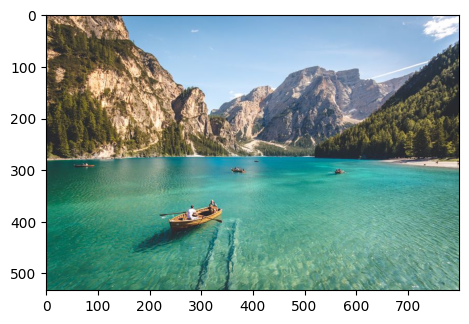

In [48]:
img_c = cv2.imread('crop_c_image')
img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)

h, w, _ = img_c.shape

plt.figure(figsize=(h/100, w/100))
plt.imshow(img_c)

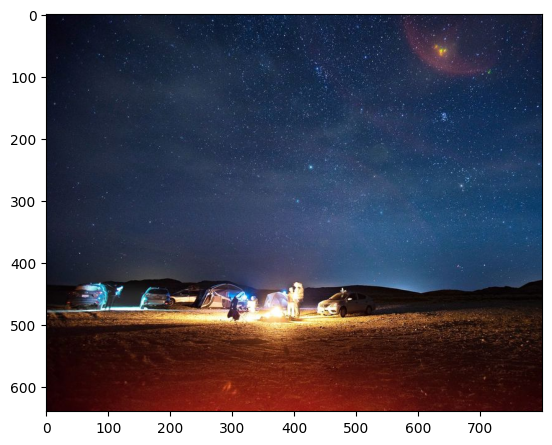

In [49]:
img_r = cv2.imread('crop_r_image')
img_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2RGB)

h, w, _ = img_r.shape

plt.figure(figsize=(h/100, w/100))
plt.imshow(img_r)

In [50]:
def calc_energy(img):
    filter_du = np.array([
        [1.0, 2.0, 1.0],
        [0.0, 0.0, 0.0],
        [-1.0, -2.0, -1.0],
    ])

    # This converts it from a 2D filter to a 3D filter, replicating the same (3 x 3) --> (3 x 3 x 3)
    # filter for each channel: R, G, B
    filter_du = np.stack([filter_du] * 3, axis=2)

    filter_dv = np.array([
        [1.0, 0.0, -1.0],
        [2.0, 0.0, -2.0],
        [1.0, 0.0, -1.0],
    ])
    # This converts it from a 2D filter to a 3D filter, replicating the same (3 x 3) --> (3 x 3 x 3)
    # filter for each channel: R, G, B
    filter_dv = np.stack([filter_dv] * 3, axis=2)

    convolved = np.sqrt(np.square(convolve(img, filter_du)) + np.square(convolve(img, filter_dv)))

    # We sum the energies in the red, green, and blue channels
    energy_map = convolved.sum(axis=2)
    return energy_map

In [51]:
def minimum_seam(img):
    r, c, _ = img.shape
    energy_map = calc_energy(img)

    M = energy_map.copy()
    backtrack = np.zeros_like(M, dtype=int)

    for i in range(1, r):
        for j in range(0, c):
            if j == 0:
                idx = np.argmin(M[i - 1, j:j + 2])
                backtrack[i, j] = idx + j
                min_energy = M[i - 1, idx + j]
            else:
                idx = np.argmin(M[i - 1, j - 1:j + 2])
                backtrack[i, j] = idx + j - 1
                min_energy = M[i - 1, idx + j - 1]

            M[i, j] += min_energy

    return M, backtrack

In [52]:
def carve_column(img): # Then, we remove the seam with the lowest energy, and return a new image

    r, c, _ = img.shape

    M, backtrack = minimum_seam(img)

    # Create a (r, c) matrix filled with the value True
    # We'll be removing all pixels from the image which have False later
    mask = np.ones((r, c), dtype=bool)

    # Find the position of the smallest element in the last row of M
    j = np.argmin(M[-1])
    for i in reversed(range(r)):
        # Mark the pixels for deletion
        mask[i, j] = False
        j = backtrack[i, j]

    # Since the image has 3 channels, we convert our mask to 3D
    mask = np.stack([mask] * 3, axis=2)

    # Delete all the pixels marked False in the mask,
    # and resize it to the new image dimensions
    img = img[mask].reshape((r, c - 1, 3))

    return img

In [53]:
def crop_c(img, scale_c):
    r, c, _ = img.shape
    new_c = int(scale_c * c)
    for i in trange(c - new_c):
      img = carve_column(img)

    return img

In [54]:
def crop_r(img, scale_r):
    img = np.rot90(img, 1)
    img = crop_c(img, scale_r)
    img = np.rot90(img, 3)
    return img

100%|██████████| 480/480 [09:11<00:00,  1.15s/it]


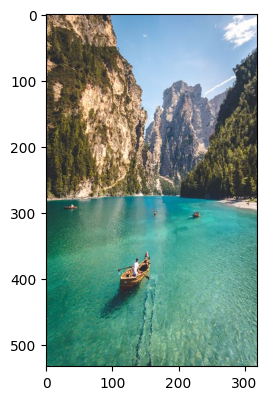

In [55]:
out_c = crop_c(img_c, 0.4)

h, w, _ = out_c.shape

plt.figure(figsize=(h/70, w/70))
plt.imshow(out_c)

100%|██████████| 320/320 [07:46<00:00,  1.46s/it]


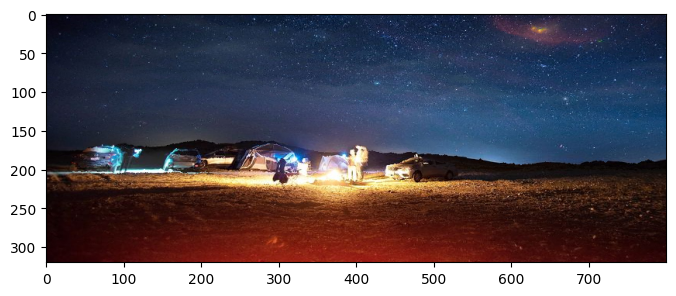

In [56]:
out_r = crop_r(img_r, 0.5)

h, w, _ = out_r.shape

plt.figure(figsize=(h/40, w/40))
plt.imshow(out_r)